In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import special as sp
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy.constants import fine_structure
rng = np.random.default_rng()

In [2]:
#variáveis e constantes

num_pon = 10000                                               #número de pontos
mean_ene = 1800                                               #energia média inicial
std_div = 90                                                  #desvio padrão
mag_field = np.array([2.5*10**6, 2.5*10**5, 2.5*10**4, 2.5*10**3]) #[T] intensidade do campo magnético
chi_0 = np.array([1, 0.1, 0.01, 0.001])                       #valores de chi
electron_charge = 1.60217663*10**(-19)                        #[C] carga fundamental do eletrão
mass_electron = 9.1093837015*10**(-31)                        #[Kg] massa do eletrao
h_bar = 6.626*10**(-34)/(2*pi)                                #[J.s] constante de planck barra
spd_light = 3 * 10**8                                         #[m/s] velocidade da luz no vazio
electron_radius = 2.8179403262e-15                            #[m] classical electron radius
tau_e = h_bar/(spd_light**2*mass_electron)                    #[s] time it takes for light to travel across the electron radius
n_bins = 100                                                 #número de bins do histograma
omega_c = electron_charge*mag_field/(mass_electron*mean_ene)  #synchrotron frequency
cnst_prop_1 = mean_ene/chi_0                                  #constante que transforma valores de chi em gamma
cnst_prop_2 = chi_0/mean_ene                                  #constante que transforma valores de gamma em chi
t_end = np.array([3, 5, 20, 20])                              #tempos finais
time_step = t_end/100                                         #time step

#valores de gamma
gamma_glob = np.array([(mean_ene + std_div*rng.standard_normal(num_pon)), (mean_ene + std_div*rng.standard_normal(num_pon)), (mean_ene + std_div*rng.standard_normal(num_pon)), (mean_ene + std_div*rng.standard_normal(num_pon))])

gamma_glob_std = np.array(gamma_glob)

In [3]:
#função h
def func_h(chi, k):
    def integration_func(x, X):
        return (2*x**2*sp.kv(5/3, x))/(2+3*x*X)**2 + (sp.kv(2/3, x)*4*x*(3*x*X)**2)/(2+3*x*X)**4

    def integration(X):
        return (9*3**0.5/(8*pi))*integrate.quad(lambda x: integration_func(x, X), 0, np.Inf)[0]

    chi_int = np.linspace(0.00001, chi_0[k]*2, int(num_pon/10))

    S = np.array([integration(x) for x in chi_int])

    func_real = CubicSpline(chi_int, S)

    return func_real(chi)

In [4]:
#função g
def func_g(chi, k):
    def integration_func(x, X):
        return (2 * x ** 3 * X**3 * sp.kv(5 / 3, x)) / (2 + 3 * x * X) ** 3 + (
                    sp.kv(2 / 3, x) * 54 * x**4 * X ** 5) / (
                           2 + 3 * x * X) ** 5

    def integration(X):
        return (9 * 3 ** 0.5 / (4 * pi)) * \
               integrate.quad(lambda x: integration_func(x, X), 0, np.Inf)[0]

    chi_int = np.linspace(0.00000000001, chi_0[k]*2, int(num_pon/10))

    R = np.array([integration(x) for x in chi_int])

    func_real = CubicSpline(chi_int, R)

    return func_real(chi)

In [5]:
#geracao de novos gamas

gamma_glob_2 = np.array(gamma_glob)  #gamma em t = tend/2

for k in range(4):
    for i in tqdm(range(int(t_end[k]/time_step[k]))):
        dW = np.sqrt(time_step[k]) * np.random.randn()
        d_gamma = np.sqrt(func_g(gamma_glob[k]*cnst_prop_2[k], k)*((2/3)*fine_structure/tau_e/omega_c[k])*gamma_glob[k]) * dW - func_h(gamma_glob[k]*cnst_prop_2[k], k)*((2/3)*fine_structure/tau_e/omega_c[k]*(gamma_glob[k]*cnst_prop_2[k])**2) * time_step[k]

        gamma_glob[k] += d_gamma

        #proibir energias negativas
        for j in range(len(gamma_glob)):
            if(gamma_glob[k][j] <= 0.0001):
                gamma_glob[k][j] = 0.0001

        if i == 9:  #gamma em t = tend/2
            gamma_glob_2[k] = np.array(gamma_glob[k])

<ipython-input-5-9d4e1e809620>:6: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for i in tqdm(range(int(t_end[k]/time_step[k]))):
100%|██████████| 100/100 [11:52<00:00,  7.12s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


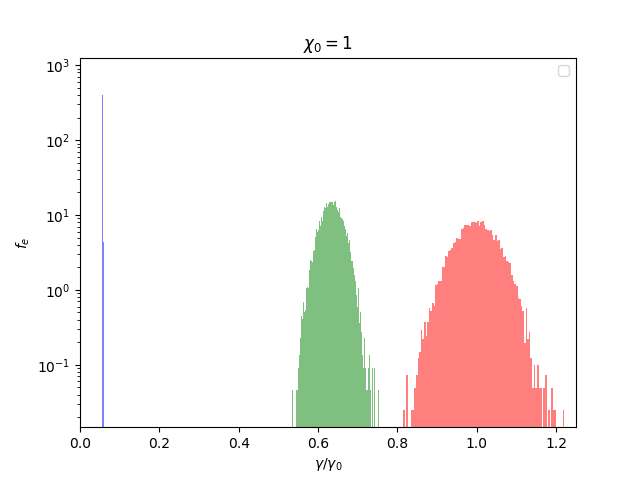

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


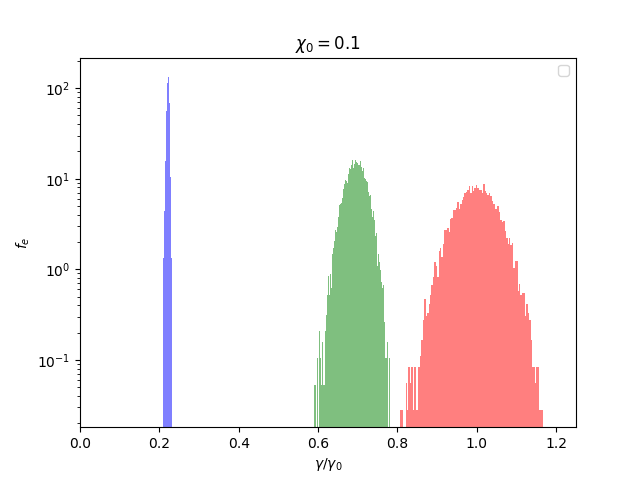

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


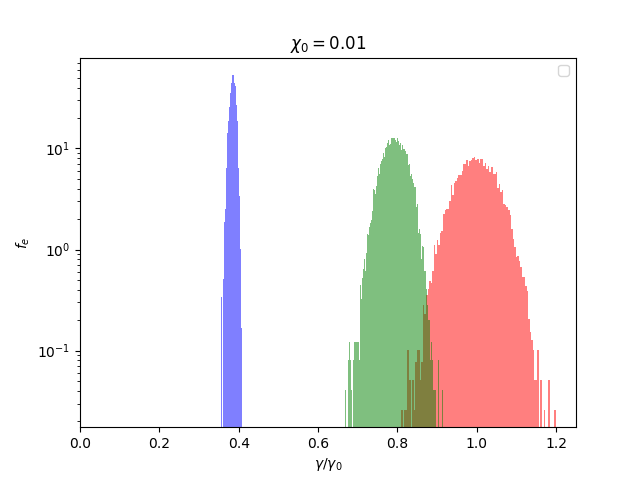

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


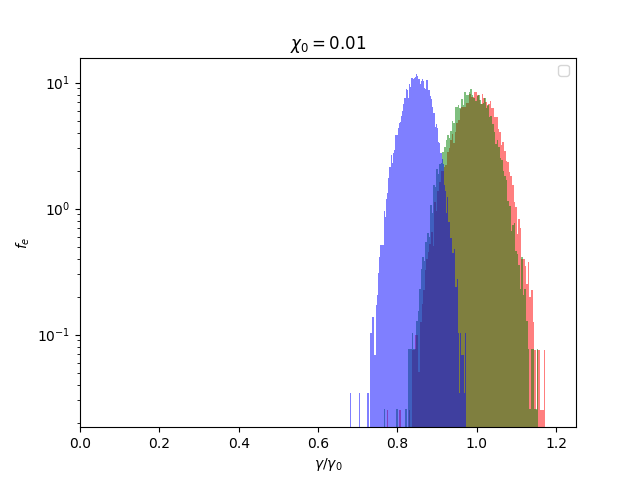

In [6]:
#gerar os histogramas
for k in range(4):
    #histograma em t=0
    plt.hist(gamma_glob_std[k] / mean_ene, n_bins, density=True,
             color='red', alpha=0.5,
             histtype='bar')

    #histograma em t = tend/2
    plt.hist(gamma_glob_2[k] / mean_ene, n_bins, density=True,
             color='green', alpha=0.5,
             histtype='bar')

    #histograma em t = tend
    plt.hist(gamma_glob[k]/mean_ene, n_bins, density=True,
                color='blue', alpha=0.5,
                histtype='bar')

    plt.yscale('log')

    plt.xlim(0, 1.25)

    if(k == 0):
        plt.title(r'${\chi_0} = 1$')
    elif (k == 1):
        plt.title(r'${\chi_0} = 0.1$')
    elif (k == 2):
        plt.title(r'${\chi_0} = 0.01$')
    else:
        plt.title(r'${\chi_0} = 0.01$')

    plt.xlabel('${\gamma}/{\gamma_0}$')

    plt.ylabel('$f_e$')

    plt.legend()

    plt.show()